In [ ]:
!odsc conda install -s fspyspark32_p38_cpu_v1

Oracle Data Science service sample notebook.

Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">PII Data redaction, Summarise Content and Translate content using doctran and open AI</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:
---
One way to think of Doctran is a LLM-powered black box where messy strings go in and nice, clean, labelled strings come out. Another way to think about it is a modular, declarative wrapper over OpenAI's functional calling feature that significantly improves the developer experience.

Benefits of Data Transformation:

1. **Redact**: Uses a spaCy model to remove names, emails, phone numbers and other sensitive information from a document. Runs locally to avoid sending sensitive data to third party APIs.
2. **Summarize**: Summarize the information in a document. token_limit may be passed to configure the size of the summary, however it may not be respected by OpenAI.
3. **Flexibility**: Remove all information from a document unless it's related to a specific set of topics.
4. **Translate**: Translates text into another language.
5. **Interrogate**: Convert information in a document into question and answer format. End user queries often take the form of a question, so converting information into questions and creating indexes from these questions often yields better results when using a vector database for context retrieval.

Compatible conda pack: [PySpark 3.2 and Feature store](https://docs.oracle.com/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.8

## Contents:

- <a href="#concepts">1. Introduction</a>
- <a href='#pre-requisites'>1. Pre-requisites</a>
    - <a href='#policies'>2.1 Policies</a>
    - <a href='#prerequisites_authentication'>2.2 Authentication</a>
    - <a href='#prerequisites_variables'>2.3 Variables</a>
- <a href='#featurestore_querying'>3. Feature store querying</a>
    - <a href='#data_exploration'>3.1. Exploration of data in feature store</a>
    - <a href='#load_featuregroup'>3.2. Load feature groups</a>
    - <a href='#explore_featuregroup'>3.3. Explore feature groups</a>
    - <a href='#select_subset_featuregroup'>3.4. Select subset of features</a>
    - <a href='#filter_featuregroup'>3.5. Filter feature groups</a>
    - <a href='#join_featuregroup'>3.6. Apply joins on feature group</a>
    - <a href='#create_dataset'>3.7. Create dataset from multiple or one feature group</a>
    - <a href='#sql_query'>3.8 Free form sql query</a>
- <a href='#ref'>4. References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

<a id="concepts"></a>
# 1. Introduction

Oracle feature store is a stack based solution that is deployed in the customer enclave using OCI resource manager. Customer can stand up the service with infrastructure in their own tenancy. The service consists of API which are deployed in customer tenancy using resource manager.

The following are some key terms that will help you understand OCI Data Science Feature Store:


* **Feature Vector**: Set of feature values for any one primary/identifier key. Eg. All/subset of features of customer id ‘2536’ can be called as one feature vector.

* **Feature**: A feature is an individual measurable property or characteristic of a phenomenon being observed.

* **Entity**: An entity is a group of semantically related features. The first step a consumer of features would typically do when accessing the feature store service is to list the entities and the entities associated features. Another way to look at it is that an entity is an object or concept that is described by its features. Examples of entities could be customer, product, transaction, review, image, document, etc.

* **Feature Group**: A feature group in a feature store is a collection of related features that are often used together in ml models. It serves as an organizational unit within the feature store for users to manage, version and share features across different ml projects. By organizing features into groups, data scientists and ml engineers can efficiently discover, reuse and collaborate on features reducing the redundant work and ensuring consistency in feature engineering.

* **Feature Group Job**: Feature group job is the execution instance of a feature group. Each feature group job will include validation results and statistics results.

* **Dataset**: A dataset is a collection of feature that are used together to either train a model or perform model inference.

* **Dataset Job**: Dataset job is the execution instance of a dataset. Each dataset job will include validation results and statistics results.

<a id='pre-requisites'></a>
# 2. Pre-requisites

Data Flow Sessions are accessible through the following conda environment:

* **PySpark 3.2, Feature store 1.0 and Data Flow 1.0 (fs_pyspark32_p38_cpu_v1)**

The [Data Catalog Hive Metastore](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm) provides schema definitions for objects in structured and unstructured data assets. The Metastore is the central metadata repository to understand tables backed by files on object storage. You can customize `fs_pyspark32_p38_cpu_v1`, publish it, and use it as a runtime environment for a Data Flow session cluster. The metastore id of hive metastore is tied to feature store construct of feature store service.


<a id='setup_spark-defaults'></a>
### `spark-defaults.conf`

The `spark-defaults.conf` file is used to define the properties that are used by Spark. A templated version is installed when you install a Data Science conda environment that supports PySpark. However, you must update the template so that the Data Catalog metastore can be accessed. You can do this manually. However, the `odsc data-catalog config` commandline tool is ideal for setting up the file because it gathers information about your environment, and uses that to build the file.

The `odsc data-catalog config` command line tool needs the `--metastore` option to define the Data Catalog metastore OCID. No other command line option is needed because settings have default values, or they take values from your notebook session environment. Following are common parameters that you may need to override.

The `--authentication` option sets the authentication mode. It supports resource principal and API keys. The preferred method for authentication is resource principal, which is sent with `--authentication resource_principal`. If you want to use API keys, then use the `--authentication api_key` option. If the `--authentication` isn't specified, API keys are used. When API keys are used, information from the OCI configuration file is used to create the `spark-defaults.conf` file.

Object Storage and Data Catalog are regional services. By default, the region is set to the region your notebook session is running in. This information is taken from the environment variable, `NB_REGION`. Use the `--region` option to override this behavior.

The default location of the `spark-defaults.conf` file is `/home/datascience/spark_conf_dir` as defined in the `SPARK_CONF_DIR` environment variable. Use the `--output` option to define the directory where to write the file.

You need to determine what settings are appropriate for your configuration. However, the following works for most configurations and is run in a terminal window.

```bash
odsc data-catalog config --authentication resource_principal --metastore <metastore_id>
```
For more assistance, use the following command in a terminal window:

```bash
odsc data-catalog config --help
```

<a id='setup_session'></a>
### Session Setup

The notebook makes connections to the Data Catalog metastore and Object Storage. In the next cell, specify the bucket URI to act as the data warehouse. Use the `warehouse_uri` variable with the `oci://<bucket_name>@<namespace_name>/<key>` format. Update the variable `metastore_id` with the OCID of the Data Catalog metastore.

python -m pip install --pre oracle-ads==2.9.0rc0<a id='policies'></a>
### 2.1. Policies
This section covers the creation of dynamic groups and policies needed to use the service.

* [Data Flow Policies](https://docs.oracle.com/iaas/data-flow/using/policies.htm/)
* [Data Catalog Metastore Required Policies](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)
* [Getting Started with Data Flow](https://docs.oracle.com/iaas/data-flow/using/dfs_getting_started.htm)
* [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)

In [1]:
!pip install --pre --no-deps oracle-ads==2.9.0rc0 

  Obtaining dependency information for oracle-ads==2.9.0rc0 from https://files.pythonhosted.org/packages/da/5a/155af49717f08104e7eabf682ffcd1344a3d78d63ff8aedb8ef392bebc6c/oracle_ads-2.9.0rc0-py3-none-any.whl.metadata
  Using cached oracle_ads-2.9.0rc0-py3-none-any.whl.metadata (11 kB)
Using cached oracle_ads-2.9.0rc0-py3-none-any.whl (4.3 MB)
  Attempting uninstall: oracle-ads
    Found existing installation: oracle-ads 2.8.8
    Uninstalling oracle-ads-2.8.8:
      Successfully uninstalled oracle-ads-2.8.8


In [25]:
!pip install doctran python-dotenv os spacy

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [ ]:
import spacy
spacy.load('en_core_web_md')

<a id="prerequisites_authentication"></a>
### 2.2. Authentication
The [Oracle Accelerated Data Science SDK (ADS)](https://docs.oracle.com/iaas/tools/ads-sdk/latest/index.html) controls the authentication mechanism with the notebook cluster.<br>
To setup authentication use the ```ads.set_auth("resource_principal")``` or ```ads.set_auth("api_key")```.

In [1]:
import ads
ads.set_auth(auth="resource_principal", client_kwargs={"service_endpoint": "<api_path>"})

<a id="prerequisites_variables"></a>
### 2.3. Variables
To run this notebook, you must provide some information about your tenancy configuration. To create and run a feature store, you must specify a `<compartment_id>` and bucket `<metastore_id>` for offline feature store.

In [2]:
import os

compartment_id = "<compartment_i>"
metastore_id = "<metastore_id>"

<a id="featurestore_querying"></a>
# 3. Feature group use cases
By default the **PySpark 3.2, Feature store and Data Flow** conda environment includes pre-installed [great-expectations](https://legacy.docs.greatexpectations.io/en/latest/reference/core_concepts/validation.html) and [deeque](https://github.com/awslabs/deequ) libraries. The joining functionality is heavily inspired by the APIs used by Pandas to merge, join or filter DataFrames. The APIs allow you to specify which features to select from which feature group, how to join them and which features to use in join conditions.

In [3]:
import warnings
warnings.filterwarnings("ignore", message="iteritems is deprecated")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
import pandas as pd
from ads.feature_store.feature_store import FeatureStore
from ads.feature_store.feature_group import FeatureGroup
from ads.feature_store.model_details import ModelDetails
from ads.feature_store.dataset import Dataset
from ads.feature_store.common.enums import DatasetIngestionMode


from ads.feature_store.feature_group_expectation import ExpectationType
from great_expectations.core import ExpectationSuite, ExpectationConfiguration
from ads.feature_store.feature_store_registrar import FeatureStoreRegistrar

  from .model_deployment_properties import ModelDeploymentProperties

  from .model_deployer import ModelDeployer

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  LooseVersion(pyarrow.__version__) >= LooseVersion("2.0.0")

  if LooseVersion(pd.__version__) >= LooseVersion("0.24"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) >= LooseVersion("1.3.0"):

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore

Implementing implicit na

<a id="data_exploration"></a>
### 3.1. Exploration of data in feature store

In [5]:
import pandas as pd

# Define the text and ID
text = """[Generated with ChatGPT]

Confidential Document - For Internal Use Only

Date: July 1, 2023

Subject: Updates and Discussions on Various Topics

Dear Team,

I hope this email finds you well. In this document, I would like to provide you with some important updates and discuss various topics that require our attention. Please treat the information contained herein as highly confidential.

Security and Privacy Measures
As part of our ongoing commitment to ensure the security and privacy of our customers' data, we have implemented robust measures across all our systems. We would like to commend John Doe (email: john.doe@example.com) from the IT department for his diligent work in enhancing our network security. Moving forward, we kindly remind everyone to strictly adhere to our data protection policies and guidelines. Additionally, if you come across any potential security risks or incidents, please report them immediately to our dedicated team at security@example.com.

HR Updates and Employee Benefits
Recently, we welcomed several new team members who have made significant contributions to their respective departments. I would like to recognize Jane Smith (SSN: 049-45-5928) for her outstanding performance in customer service. Jane has consistently received positive feedback from our clients. Furthermore, please remember that the open enrollment period for our employee benefits program is fast approaching. Should you have any questions or require assistance, please contact our HR representative, Michael Johnson (phone: 418-492-3850, email: michael.johnson@example.com).

Marketing Initiatives and Campaigns
Our marketing team has been actively working on developing new strategies to increase brand awareness and drive customer engagement. We would like to thank Sarah Thompson (phone: 415-555-1234) for her exceptional efforts in managing our social media platforms. Sarah has successfully increased our follower base by 20% in the past month alone. Moreover, please mark your calendars for the upcoming product launch event on July 15th. We encourage all team members to attend and support this exciting milestone for our company.

Research and Development Projects
In our pursuit of innovation, our research and development department has been working tirelessly on various projects. I would like to acknowledge the exceptional work of David Rodriguez (email: david.rodriguez@example.com) in his role as project lead. David's contributions to the development of our cutting-edge technology have been instrumental. Furthermore, we would like to remind everyone to share their ideas and suggestions for potential new projects during our monthly R&D brainstorming session, scheduled for July 10th.

Please treat the information in this document with utmost confidentiality and ensure that it is not shared with unauthorized individuals. If you have any questions or concerns regarding the topics discussed, please do not hesitate to reach out to me directly.

Thank you for your attention, and let's continue to work together to achieve our goals.

Best regards,

Jason Fan
Cofounder & CEO
Psychic
jason@psychic.dev"""

document_id = 1

df = pd.DataFrame({'id': [document_id], 'letter': [text]})
df

,id,letter
0,1,"[Generated with ChatGPT]\n\nConfidential Document - For Internal Use Only\n\nDate: July 1, 2023\n\nSubject: Updates and Discussions on Various Topics\n\nDear Team,\n\nI hope this email finds you well. In this document, I would like to provide you with some important updates and discuss various topics that require our attention. Please treat the information contained herein as highly confidential.\n\nSecurity and Privacy Measures\nAs part of our ongoing commitment to ensure the security and privacy of our customers' data, we have implemented robust measures across all our systems. We would like to commend John Doe (email: john.doe@example.com) from the IT department for his diligent work in enhancing our network security. Moving forward, we kindly remind everyone to strictly adhere to our data protection policies and guidelines. Additionally, if you come across any potential security risks or incidents, please report them immediately to our dedicated team at security@example.com.\n\nHR Updates and Employee Benefits\nRecently, we welcomed several new team members who have made significant contributions to their respective departments. I would like to recognize Jane Smith (SSN: 049-45-5928) for her outstanding performance in customer service. Jane has consistently received positive feedback from our clients. Furthermore, please remember that the open enrollment period for our employee benefits program is fast approaching. Should you have any questions or require assistance, please contact our HR representative, Michael Johnson (phone: 418-492-3850, email: michael.johnson@example.com).\n\nMarketing Initiatives and Campaigns\nOur marketing team has been actively working on developing new strategies to increase brand awareness and drive customer engagement. We would like to thank Sarah Thompson (phone: 415-555-1234) for her exceptional efforts in managing our social media platforms. Sarah has successfully increased our follower base by 20% in the past month alone. Moreover, please mark your calendars for the upcoming product launch event on July 15th. We encourage all team members to attend and support this exciting milestone for our company.\n\nResearch and Development Projects\nIn our pursuit of innovation, our research and development department has been working tirelessly on various projects. I would like to acknowledge the exceptional work of David Rodriguez (email: david.rodriguez@example.com) in his role as project lead. David's contributions to the development of our cutting-edge technology have been instrumental. Furthermore, we would like to remind everyone to share their ideas and suggestions for potential new projects during our monthly R&D brainstorming session, scheduled for July 10th.\n\nPlease treat the information in this document with utmost confidentiality and ensure that it is not shared with unauthorized individuals. If you have any questions or concerns regarding the topics discussed, please do not hesitate to reach out to me directly.\n\nThank you for your attention, and let's continue to work together to achieve our goals.\n\nBest regards,\n\nJason Fan\nCofounder & CEO\nPsychic\njason@psychic.dev"


<a id="load_featuregroup"></a>
### 3.2. Create feature store logical entities

#### 3.2.1 Feature Store
Feature store is the top level entity for feature store service

In [6]:
feature_store_resource = (
    FeatureStore().
    with_description("Data Redaction Feature Store").
    with_compartment_id(compartment_id).
    with_display_name("Data redaction").
    with_offline_config(metastore_id=metastore_id)
)

<a id="create_feature_store"></a>
##### Create Feature Store

Call the ```.create()``` method of the Feature store instance to create a feature store.

In [7]:
feature_store = feature_store_resource.create()
feature_store


kind: featurestore
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Data Redaction Feature Store
  displayName: Data redaction
  id: E8A14F21A0E746EC7470D62D5F18EF85
  offlineConfig:
    metastoreId: ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxyap7tizm4gscwz7amu7dixz7ml3mtesqzzwwg3urvvdgua
type: featureStore

#### 3.2.2 Entity
An entity is a logical segregation of feature store entities

In [8]:
entity = feature_store.create_entity(
    display_name="Data Redaction Feature Store",
    description="Data Redaction Feature Store"
)
entity


kind: entity
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Data Redaction Feature Store
  featureStoreId: E8A14F21A0E746EC7470D62D5F18EF85
  id: 488CBD7C038DA49C77B5C8C13094BFD4
  name: Data Redaction Feature Store
type: entity

#### 3.2.3 Transformation

In [9]:
def transform_dataframe(input_df, content_column='letter'):
    import pandas as pd
    from doctran import Doctran
    import dotenv
    import os
    dotenv.load_dotenv()
    OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
    OPENAI_MODEL = "gpt-4"
    OPENAI_TOKEN_LIMIT = 8000

    # Function to apply transformations to each row
    def apply_transformations(row):
        doctran = Doctran(openai_api_key=OPENAI_API_KEY, openai_model=OPENAI_MODEL, openai_token_limit=OPENAI_TOKEN_LIMIT)
        document = doctran.parse(content=row[content_column])
        transformed_document = (document
                                .redact(entities=["PERSON", "EMAIL_ADDRESS", "PHONE_NUMBER", "US_SSN"])
                                .summarize(token_limit=10)
                                .translate(language="french")
                                .execute()
                                )

        return transformed_document.transformed_content

    # Apply the transformations to each row
    input_df['transformed_content'] = input_df.apply(apply_transformations, axis=1)
    return input_df

In [10]:
from ads.feature_store.transformation import TransformationMode

pii_data_redaction_transformation = feature_store.create_transformation(
    transformation_mode=TransformationMode.PANDAS,
    source_code_func=transform_dataframe,
    display_name="transform_dataframe",
)

pii_data_redaction_transformation


kind: transformation
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  displayName: transform_dataframe
  featureStoreId: E8A14F21A0E746EC7470D62D5F18EF85
  id: EA2BC47BD5DDF318148DC478EE78F71D
  sourceCode: ZGVmIHRyYW5zZm9ybV9kYXRhZnJhbWUoaW5wdXRfZGYsIGNvbnRlbnRfY29sdW1uPSdsZXR0ZXInKToKICAgIGltcG9ydCBwYW5kYXMgYXMgcGQKICAgIGZyb20gZG9jdHJhbiBpbXBvcnQgRG9jdHJhbgogICAgaW1wb3J0IGRvdGVudgogICAgaW1wb3J0IG9zCiAgICBkb3RlbnYubG9hZF9kb3RlbnYoKQogICAgT1BFTkFJX0FQSV9LRVkgPSBvcy5nZXRlbnYoIk9QRU5BSV9BUElfS0VZIikKICAgIE9QRU5BSV9NT0RFTCA9ICJncHQtNCIKICAgIE9QRU5BSV9UT0tFTl9MSU1JVCA9IDgwMDAKCiAgICAjIEZ1bmN0aW9uIHRvIGFwcGx5IHRyYW5zZm9ybWF0aW9ucyB0byBlYWNoIHJvdwogICAgZGVmIGFwcGx5X3RyYW5zZm9ybWF0aW9ucyhyb3cpOgogICAgICAgIGRvY3RyYW4gPSBEb2N0cmFuKG9wZW5haV9hcGlfa2V5PU9QRU5BSV9BUElfS0VZLCBvcGVuYWlfbW9kZWw9T1BFTkFJX01PREVMLCBvcGVuYWlfdG9rZW5fbGltaXQ9T1BFTkFJX1RPS0VOX0xJTUlUKQogICAgICAgIGRvY3VtZW50ID0gZG9jdHJhbi5wYXJzZShjb250ZW50PXJvd1tjb250ZW50X2NvbHVtbl0p

#### 3.2.3 Feature group
A feature group is an object that represents a logical group of time-series feature data as it is found in a datasource.

<a id="create_feature_group_flights"></a>
##### PII redaction feature Group

Create feature group for PII Redaction Feature Group

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/feature_group_flights.gif" width="700" height="350" />
</div>

In [11]:
data_redaction_feature_group = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys([])
    .with_name("data_redaction_fg")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(df)
    .with_transformation_id(pii_data_redaction_transformation.id)
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023/11/11 07:54:41 NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



In [12]:
data_redaction_feature_group.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 488CBD7C038DA49C77B5C8C13094BFD4
  featureStoreId: E8A14F21A0E746EC7470D62D5F18EF85
  id: 7F5265FE17466AD35C0ED2DEA14A7080
  inputFeatureDetails:
  - featureType: LONG
    name: id
    orderNumber: 1
  - featureType: STRING
    name: letter
    orderNumber: 2
  isInferSchema: true
  name: data_redaction_fg
  primaryKeys:
    items: []
  statisticsConfig:
    isEnabled: true
  transformationId: EA2BC47BD5DDF318148DC478EE78F71D
  transformationParameters: e30=
type: featureGroup

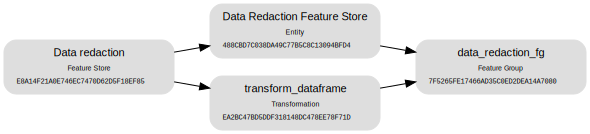

In [13]:
data_redaction_feature_group.show()

In [14]:
data_redaction_feature_group.materialise(df)

Hive Session ID = 36e117f9-b568-4a23-9817-cedc8adb1937


INFO:presidio-analyzer:Created NLP engine: spacy. Loaded models: ['en']
INFO:presidio-analyzer:registry not provided, creating default.
INFO:presidio-analyzer:Loaded recognizer: UsBankRecognizer
INFO:presidio-analyzer:Loaded recognizer: UsLicenseRecognizer
INFO:presidio-analyzer:Loaded recognizer: UsItinRecognizer
INFO:presidio-analyzer:Loaded recognizer: UsPassportRecognizer
INFO:presidio-analyzer:Loaded recognizer: UsSsnRecognizer
INFO:presidio-analyzer:Loaded recognizer: NhsRecognizer
INFO:presidio-analyzer:Loaded recognizer: SgFinRecognizer
INFO:presidio-analyzer:Loaded recognizer: AuAbnRecognizer
INFO:presidio-analyzer:Loaded recognizer: AuAcnRecognizer
INFO:presidio-analyzer:Loaded recognizer: AuTfnRecognizer
INFO:presidio-analyzer:Loaded recognizer: AuMedicareRecognizer
INFO:presidio-analyzer:Loaded recognizer: InPanRecognizer
INFO:presidio-analyzer:Loaded recognizer: CreditCardRecognizer
INFO:presidio-analyzer:Loaded recognizer: CryptoRecognizer
INFO:presidio-analyzer:Loaded re

INFO:mlm_insights.builder:validating required components
INFO:mlm_insights.builder:required components validated
INFO:mlm_insights.builder.usage:Activating Minimal Insights Usage
INFO:mlm_insights.builder:Generating Runner object
INFO:mlm_insights.builder:Generating workflow request
INFO:mlm_insights.workflow:Fetching engine object
INFO:mlm_insights.workflow:Returning native engine object
INFO:mlm_insights.builder:Running Fugue Workflow
INFO:mlm_insights.workflow:Executing Fugue Workflow


INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f70a52f01f0>), 'c19e3960aa08a392d20aaa5da607d9ea': DescriptiveStatisticsSFC(total_count=1.0, mean=1.0, minimum=1.0, maximum=1.0, central_moments=[1.0, 0.0, 0.0, 0.0, 0.0]), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f70a5244ab0>), '6e3ac490990d92bca69c828fe3aff8ad': QuantilesSFC(kll_sketch=<_datasketches.kll_doubles_sketch object at 0x7f70a52fa170>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f70b017c030>), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f70a52fa0f0>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.freque

/home/datascience/conda/fspyspark32_p38_cpu_v1/lib/python3.8/site-packages/mlm_insights/core/sfcs/descriptive_statistics_sfc.py:80: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  self.central_moments = [moment(column, moment=i) for i in range(MAXIMUM_MOMENT_ORDER + 1)]


<a id="explore_featuregroup"></a>
### 3.3. Explore feature groups

In [15]:
# synthetic_data_embedding_feature_group.get_statistics().to_viz()

In [16]:
data_redaction_feature_group.history().show()

+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|          timestamp|userId|userName|           operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      0|2023-11-11 07:55:29|  null|    null|CREATE OR REPLACE...|{isManaged -> tru...|null|    null|     null|       null|  Serializable|        false|{numFiles -> 1, n...|        null|Apache-Spark/3.2....|
+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+----------------

In [17]:
data_redaction_feature_group.as_of(version_number=0).show()

+---+--------------------+--------------------+
| id|              letter| transformed_content|
+---+--------------------+--------------------+
|  1|[Generated with C...|Mise à jour inter...|
+---+--------------------+--------------------+



In [18]:
data_redaction_feature_group.get_features_df()

,name,type
0,id,LONG
1,letter,STRING
2,transformed_content,STRING


In [19]:
data_redaction_feature_group.select().show()

+---+--------------------+--------------------+
| id|              letter| transformed_content|
+---+--------------------+--------------------+
|  1|[Generated with C...|Mise à jour inter...|
+---+--------------------+--------------------+



<a id="select_subset_featuregroup"></a>
### 3.4. Select subset of features

In [20]:
data_redaction_feature_group.select(['letter', 'transformed_content']).show()

+--------------------+--------------------+
|              letter| transformed_content|
+--------------------+--------------------+
|[Generated with C...|Mise à jour inter...|
+--------------------+--------------------+



In [23]:
data_redaction_feature_group.select().show()

+---+--------------------+--------------------+
| id|              letter| transformed_content|
+---+--------------------+--------------------+
|  1|[Generated with C...|Mise à jour inter...|
+---+--------------------+--------------------+



<a id="filter_featuregroup"></a>
### 3.5. Filter feature groups

In [25]:
tranining_df = data_redaction_feature_group.select().read().toPandas()
tranining_df

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



,id,letter,transformed_content
0,1,"[Generated with ChatGPT]\n\nConfidential Document - For Internal Use Only\n\nDate: July 1, 2023\n\nSubject: Updates and Discussions on Various Topics\n\nDear Team,\n\nI hope this email finds you well. In this document, I would like to provide you with some important updates and discuss various topics that require our attention. Please treat the information contained herein as highly confidential.\n\nSecurity and Privacy Measures\nAs part of our ongoing commitment to ensure the security and privacy of our customers' data, we have implemented robust measures across all our systems. We would like to commend John Doe (email: john.doe@example.com) from the IT department for his diligent work in enhancing our network security. Moving forward, we kindly remind everyone to strictly adhere to our data protection policies and guidelines. Additionally, if you come across any potential security risks or incidents, please report them immediately to our dedicated team at security@example.com.\n\nHR Updates and Employee Benefits\nRecently, we welcomed several new team members who have made significant contributions to their respective departments. I would like to recognize Jane Smith (SSN: 049-45-5928) for her outstanding performance in customer service. Jane has consistently received positive feedback from our clients. Furthermore, please remember that the open enrollment period for our employee benefits program is fast approaching. Should you have any questions or require assistance, please contact our HR representative, Michael Johnson (phone: 418-492-3850, email: michael.johnson@example.com).\n\nMarketing Initiatives and Campaigns\nOur marketing team has been actively working on developing new strategies to increase brand awareness and drive customer engagement. We would like to thank Sarah Thompson (phone: 415-555-1234) for her exceptional efforts in managing our social media platforms. Sarah has successfully increased our follower base by 20% in the past month alone. Moreover, please mark your calendars for the upcoming product launch event on July 15th. We encourage all team members to attend and support this exciting milestone for our company.\n\nResearch and Development Projects\nIn our pursuit of innovation, our research and development department has been working tirelessly on various projects. I would like to acknowledge the exceptional work of David Rodriguez (email: david.rodriguez@example.com) in his role as project lead. David's contributions to the development of our cutting-edge technology have been instrumental. Furthermore, we would like to remind everyone to share their ideas and suggestions for potential new projects during our monthly R&D brainstorming session, scheduled for July 10th.\n\nPlease treat the information in this document with utmost confidentiality and ensure that it is not shared with unauthorized individuals. If you have any questions or concerns regarding the topics discussed, please do not hesitate to reach out to me directly.\n\nThank you for your attention, and let's continue to work together to achieve our goals.\n\nBest regards,\n\nJason Fan\nCofounder & CEO\nPsychic\njason@psychic.dev","Mise à jour interne confidentielle sur les mesures de sécurité, les nouvelles RH, les initiatives marketing et les projets de R&D."


<a id='ref'></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)